Thanh Truc Bui

In [38]:
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import pydot
import h5py
import math
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.tree import export_graphviz
from sklearn.metrics import matthews_corrcoef, f1_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, make_scorer
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import optuna

import pickle # save model

load_dotenv() # load environment variables

abs_path_to_split30_fasta = os.getenv("FASTA_ENZYMES","not found")
abs_path_to_non_enzyme_fasta = os.getenv("FASTA_NON_ENZYMES","not found")
path_to_split100_fasta="/home/trucbui/PycharmProjects/PBL2324/venv/Dataset/rostlab.org_public_senoner_pbl_2023_split100.fasta.txt"


<font size="5">Read the protein mass table</font>

In [2]:

def read_mass_csv(path):  
    masses={}
    with open(path, "r") as file:
        for line in file:
            info = line.split("\t")
            char = info[0]
            mass = info[1]
            masses[char] = mass
    return masses

protein_masses=read_mass_csv(r'/home/trucbui/PBLGit/random_forest/mass.tsv')

def cal_mass(seq):
    mass = 0.0
    for char in seq:
        if char in protein_masses.keys():
            mass += float(protein_masses[char])
    mass = round(mass, 3)
    return mass


<font size="5">Create a protein class</font>

In [3]:

class Protein:
    def __init__(self, header, seq, is_enzyme):
        self.header = header
        self.seq=seq
        self.mass=cal_mass(seq)
        self.is_enzyme=is_enzyme
        self.embeddings=None
        self.emb_median=0.0
        self.emb_std=0.0
        self.emb_magnitude=0.0
        self.last_aa=seq[-1:]
        
        


<font size="5">Read data from fasta file</font>

In [4]:

def readfasta(fasta:str, is_enzyme:bool) -> dict: 
    seq_map=dict()
    enzyme=0
    if is_enzyme==True:
        enzyme=1
    with open(fasta, "r") as path:
        seq = ""
        header = path.readline().rstrip()[1:]
        for line in path.readlines():
            if line.startswith(">"):
                seq_map[header]=Protein(header,seq,enzyme)
                seq = ""
                header = line.rstrip()[1:]
            else:
                seq += line.rstrip()
        seq_map[header]=Protein(header,seq,enzyme)
    return seq_map

enzymes_map=readfasta(abs_path_to_split30_fasta,True)
non_enzymes_map=readfasta(abs_path_to_non_enzyme_fasta,False)
#enzymes_split100_map=readfasta(path_to_split100_fasta,True)


<font size="5">Read data from esm2 embeddings</font>

In [5]:
def magnitude(vector):
    return math.sqrt(sum(pow(element, 2) for element in vector))

In [6]:
def PCA_for_emb(emb:list,n:int):   #Reducing the embedding vector to n dimensions
    pca = PCA(n_components=n)
    emb_pca = pca.fit_transform(emb)
    return emb_pca


In [7]:

def read_esm2(path_to_esm2:str,seq_map:dict) -> dict: 
    protein_map=seq_map
    with h5py.File(path_to_esm2) as hdf_handle:
        for header, emb in hdf_handle.items():
            if header in seq_map.keys():
                protein_map[header].embeddings = a = np.array(list(emb))
                protein_map[header].emb_median=np.median(a)                
                protein_map[header].emb_std=np.std(a)
                protein_map[header].emb_magnitude=magnitude(a)

    return protein_map


enzymes_map = read_esm2(os.getenv("ESM2_ENZYMES_SPLIT_30"),enzymes_map)
non_enzymes_map = read_esm2(os.getenv("ESM2_NON_ENZYMES"),non_enzymes_map)


<font size="5">Find out the most common last amino acid of the enzymes and non-enzymes set</font>

In [8]:
"""
def most_common_last_aa(seq_map:dict):
    last_aa_list=dict()
    for header in seq_map.keys():
        last=seq_map[header].last_aa
        if not last in last_aa_list:
            last_aa_list[last] = 0
        last_aa_list[last]+=1
    common_aa=[]
    for aa in last_aa_list.keys():
        if not aa=="X":
            if (last_aa_list[aa]/len(seq_map))>0.09:
                common_aa.append(aa)
                print (last_aa_list[aa]/len(seq_map))
    return common_aa

enzymes_common_last_aa=most_common_last_aa(enzymes_map)
print(enzymes_common_last_aa)
non_enzymes_common_last_aa=most_common_last_aa(non_enzymes_map)
print(non_enzymes_common_last_aa)
"""


'\ndef most_common_last_aa(seq_map:dict):\n    last_aa_list=dict()\n    for header in seq_map.keys():\n        last=seq_map[header].last_aa\n        if not last in last_aa_list:\n            last_aa_list[last] = 0\n        last_aa_list[last]+=1\n    common_aa=[]\n    for aa in last_aa_list.keys():\n        if not aa=="X":\n            if (last_aa_list[aa]/len(seq_map))>0.09:\n                common_aa.append(aa)\n                print (last_aa_list[aa]/len(seq_map))\n    return common_aa\n\nenzymes_common_last_aa=most_common_last_aa(enzymes_map)\nprint(enzymes_common_last_aa)\nnon_enzymes_common_last_aa=most_common_last_aa(non_enzymes_map)\nprint(non_enzymes_common_last_aa)\n'

The most common last amino acids are not significant and thus will be ignored

<font size="5">Looking for some kmers<font>

In [9]:
def hamming_distance(Genome1:str, Genome2:str):
    distance=0
    for i in range(len(Genome1)):
        if Genome1[i]!=Genome2[i]:
            distance+=1
    return distance

def neighbors(Pattern: str, d: int):
    if d==0:
        return [Pattern]
    
    if len(Pattern)==1:
        return ['A', 'C', 'G', 'T']
    
    neighborhood=[]
    suffix_neighbors=neighbors(Pattern[1:], d)
    for text in suffix_neighbors:
        if hamming_distance(Pattern[1:], text)<d:
            for x in ['A', 'C', 'G', 'T']:
                neighborhood.append(x+text)
        else:
            neighborhood.append(Pattern[0]+text)
    return neighborhood

def max_map(freq_map):
    max=0
    for key in freq_map.keys():
        if freq_map[key]>max:
            max=freq_map[key]
    return max

def kmer_with_max_d_mismatch(protein_map:dict(), k:int, d: int):
    Patterns=[]
    kmers_map=dict()

    for protein in protein_map.keys():
        Text=protein_map[protein].seq
        for i in range(len(Text)-k+1):
            Pattern=Text[i:i+k]
            neigherborhood=neighbors(Pattern, d)
            for j in range(len(neigherborhood)):    #Every neighbor of a pattern can be a key in the map. Now we find out which key has the highest value
                neighbor=neigherborhood[j]
                if not neighbor in kmers_map.keys():
                    kmers_map[neighbor]=1
                else:
                    kmers_map[neighbor]+=1
    
    m=max_map(kmers_map)
    for key in kmers_map.keys():
        if kmers_map[key]==m:
            Patterns.append(key)
    
    return Patterns


In [10]:
#kmer_with_max_d_mismatch(enzymes_map, 20, 1)


In [11]:
#kmer_with_max_d_mismatch(non_enzymes_map, 20, 1)


Pick the best n for the PCA

In [12]:
embs_enzymes=[]
embs_non_enzymes=[]

for protein in enzymes_map.keys():
    embs_enzymes.append(enzymes_map[protein].embeddings)
for protein in non_enzymes_map.keys():
    embs_non_enzymes.append(non_enzymes_map[protein].embeddings)



In [13]:

def pick_n_for_pca(embs):
    pca = PCA().fit(embs)
    plt.rcParams["figure.figsize"] = (12,6)

    fig, ax = plt.subplots()
    xi = np.arange(1, 2561, step=1)
    y = np.cumsum(pca.explained_variance_ratio_)

    n_components_90_percent = np.argmax(y >= 0.90) + 1


    plt.ylim(0.0,1.1)
    plt.plot(xi, y, marker='o', linestyle='--', color='#ff7f00')

    plt.xlabel('Number of Components')
    plt.xticks([256,512,700,1024,2048,2560])    
    plt.ylabel('Cumulative variance (%)')
    plt.title('The number of components needed to explain variance')

    plt.axhline(y=0.90, color='#377eb8', linestyle='-')
    plt.text(0.8, 0.85, '90% cut-off threshold', color = '#377eb8', fontsize=16)

    ax.grid(axis='x')
    plt.show()

    return n_components_90_percent


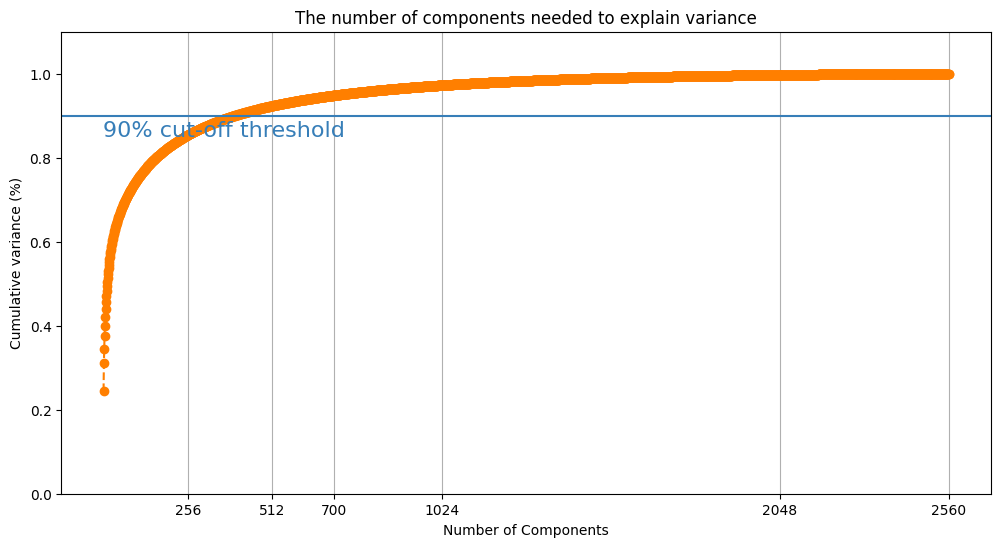

397

In [14]:

pick_n_for_pca(embs_enzymes)

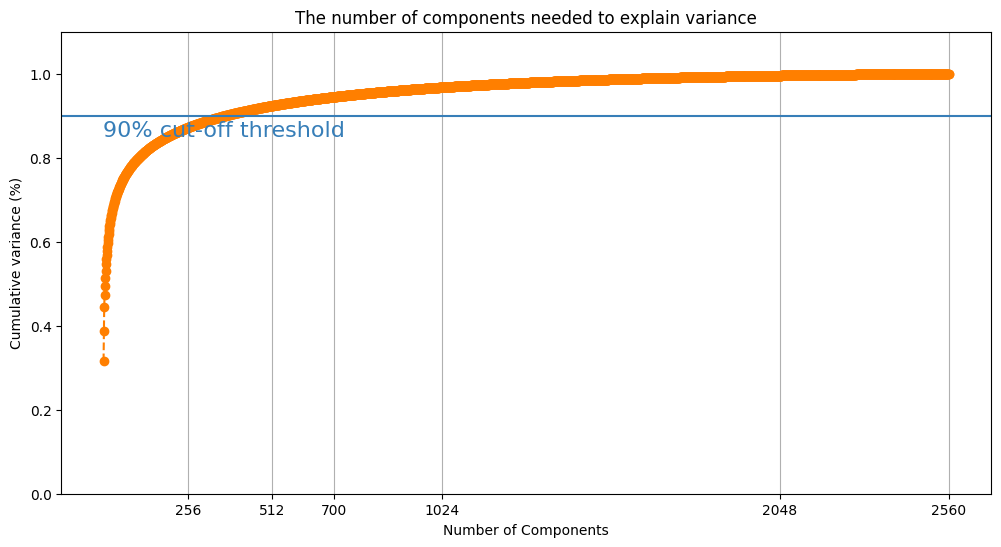

369

In [15]:
pick_n_for_pca(embs_non_enzymes)

Now that with n=700 we get 90% cut off, we choose PCA with 397 dimension

In [16]:
n_dimensions_after_pca=397

<font size="5">Create a dataframe<font>

In [17]:
def making_df(seq_map:dict)-> pd.DataFrame(): 
    headers=[]
    mass=[]
    labels=[]
    embs=[]
    emb_median_all=[]
    emb_std_all=[]
    emb_magnitude_all=[]
    seqs=[]
    
    
    for header in seq_map:
        headers.append(header)
        entry=seq_map[header]
        labels.append(entry.is_enzyme)
        mass.append(entry.mass)
        embs.append(entry.embeddings)
        emb_median_all.append(entry.emb_median)     
        emb_std_all.append(entry.emb_std)
        emb_magnitude_all.append(entry.emb_magnitude)
        seqs.append(entry.seq)
        
    emb_pca_all=PCA_for_emb(np.array(embs),n_dimensions_after_pca).tolist()

    
    return pd.DataFrame(data={'Label':labels ,'Entry':headers,'Mass':mass, 'Emb':embs, 'Emb median': emb_median_all, 
    'Emb std': emb_std_all, 'Emb magnitude': emb_magnitude_all, 'Emb PCA': emb_pca_all})


In [18]:

enzymes_df=making_df(enzymes_map)
enzymes_df=enzymes_df.sort_values(['Entry'],ascending=[True])

non_enzymes_df=making_df(non_enzymes_map)
non_enzymes_df=non_enzymes_df.sort_values(['Entry'],ascending=[True])

df=pd.concat([enzymes_df,non_enzymes_df],axis=0)
df=df.reset_index(drop=True)
print(df)


       Label       Entry        Mass  \
0          1  A0A024RBG1   20403.292   
1          1  A0A024SMV2   42741.490   
2          1  A0A060S684   63631.543   
3          1  A0A075TXZ3   61430.846   
4          1  A0A077K8G3   45202.778   
...      ...         ...         ...   
48701      0      X2JAU8  117164.590   
48702      0      X5HYT8   46670.171   
48703      0      X5LX76  118226.070   
48704      0      X6R8D5   14504.182   
48705      0      X6R8R1   52161.639   

                                                     Emb  Emb median  \
0      [-0.015143169, 0.035552002, -0.02231326, 0.002...   -0.003883   
1      [0.059097216, -0.034141198, 0.061426997, 0.006...   -0.002613   
2      [-0.016934631, -0.04490467, 0.0054878886, -0.0...   -0.002250   
3      [-0.06815035, -0.034723807, 0.03341713, -0.057...   -0.001353   
4      [-0.03639361, 0.046453245, 0.06140146, -0.0697...   -0.004369   
...                                                  ...         ...   
48701  [-0.0968

In [19]:
df.to_csv(r'/home/trucbui/PBLGit/random_forest/split30_and_non_enzymes_with_esm2_df.csv', index = False)

<font size="5">Train the model</font>

Duplicate the enzymes class to achieve a balanced dataframe

In [20]:
enzymes_df_dup=enzymes_df.loc[enzymes_df.index.repeat(4)].reset_index(drop=True)
enzymes_df_dup

,Label,Entry,Mass,Emb,Emb median,Emb std,Emb magnitude,Emb PCA
0,1,A0A024RBG1,20403.292,"[-0.015143169, 0.035552002, -0.02231326, 0.002...",-0.003883,0.246559,12.475115,"[-0.720111072063446, 0.14486780762672424, 0.30..."
1,1,A0A024RBG1,20403.292,"[-0.015143169, 0.035552002, -0.02231326, 0.002...",-0.003883,0.246559,12.475115,"[-0.720111072063446, 0.14486780762672424, 0.30..."
2,1,A0A024RBG1,20403.292,"[-0.015143169, 0.035552002, -0.02231326, 0.002...",-0.003883,0.246559,12.475115,"[-0.720111072063446, 0.14486780762672424, 0.30..."
3,1,A0A024RBG1,20403.292,"[-0.015143169, 0.035552002, -0.02231326, 0.002...",-0.003883,0.246559,12.475115,"[-0.720111072063446, 0.14486780762672424, 0.30..."
4,1,A0A024SMV2,42741.490,"[0.059097216, -0.034141198, 0.061426997, 0.006...",-0.002613,0.224955,11.381984,"[1.1132574081420898, -0.09059973806142807, -0...."
...,...,...,...,...,...,...,...,...
36811,1,W8QRE4,55422.596,"[0.020590644, -0.07072362, -0.039977305, -0.05...",-0.003280,0.226045,11.437125,"[1.1221401691436768, 0.019742624834179878, -0...."
36812,1,X1WBB5,31128.858,"[-0.0059736804, 0.052732702, 0.031979043, -0.0...",-0.002315,0.259171,13.113278,"[-1.2896618843078613, -0.05930933728814125, 0...."
36813,1,X1WBB5,31128.858,"[-0.0059736804, 0.052732702, 0.031979043, -0.0...",-0.002315,0.259171,13.113278,"[-1.2896618843078613, -0.05930933728814125, 0...."
36814,1,X1WBB5,31128.858,"[-0.0059736804, 0.052732702, 0.031979043, -0.0...",-0.002315,0.259171,13.113278,"[-1.2896618843078613, -0.05930933728814125, 0...."


In [21]:
df_with_enzyme_dup=pd.concat([enzymes_df_dup,non_enzymes_df,],axis=0)
df_with_enzyme_dup=df_with_enzyme_dup.reset_index(drop=True)
df_with_enzyme_dup

,Label,Entry,Mass,Emb,Emb median,Emb std,Emb magnitude,Emb PCA
0,1,A0A024RBG1,20403.292,"[-0.015143169, 0.035552002, -0.02231326, 0.002...",-0.003883,0.246559,12.475115,"[-0.720111072063446, 0.14486780762672424, 0.30..."
1,1,A0A024RBG1,20403.292,"[-0.015143169, 0.035552002, -0.02231326, 0.002...",-0.003883,0.246559,12.475115,"[-0.720111072063446, 0.14486780762672424, 0.30..."
2,1,A0A024RBG1,20403.292,"[-0.015143169, 0.035552002, -0.02231326, 0.002...",-0.003883,0.246559,12.475115,"[-0.720111072063446, 0.14486780762672424, 0.30..."
3,1,A0A024RBG1,20403.292,"[-0.015143169, 0.035552002, -0.02231326, 0.002...",-0.003883,0.246559,12.475115,"[-0.720111072063446, 0.14486780762672424, 0.30..."
4,1,A0A024SMV2,42741.490,"[0.059097216, -0.034141198, 0.061426997, 0.006...",-0.002613,0.224955,11.381984,"[1.1132574081420898, -0.09059973806142807, -0...."
...,...,...,...,...,...,...,...,...
76313,0,X2JAU8,117164.590,"[-0.09689512, -0.090523794, -0.016701577, -0.0...",-0.003210,0.218149,11.037591,"[3.92879581451416, 1.054029107093811, 0.070148..."
76314,0,X5HYT8,46670.171,"[0.0023819576, -0.033620838, 0.043625146, -0.0...",-0.003682,0.267518,13.535640,"[-0.8071572184562683, 0.2815758287906647, 0.49..."
76315,0,X5LX76,118226.070,"[-0.0035375275, -0.021880746, -0.028436316, 0....",-0.003806,0.255798,12.942582,"[0.0361863374710083, -0.42618682980537415, -0...."
76316,0,X6R8D5,14504.182,"[-0.009083768, -0.058401734, 0.022719534, -0.0...",-0.004650,0.287314,14.537300,"[-2.6940057277679443, 2.3132107257843018, 0.50..."


PCA -> df

In [22]:
df_with_enzyme_dup

,Label,Entry,Mass,Emb,Emb median,Emb std,Emb magnitude,Emb PCA
0,1,A0A024RBG1,20403.292,"[-0.015143169, 0.035552002, -0.02231326, 0.002...",-0.003883,0.246559,12.475115,"[-0.720111072063446, 0.14486780762672424, 0.30..."
1,1,A0A024RBG1,20403.292,"[-0.015143169, 0.035552002, -0.02231326, 0.002...",-0.003883,0.246559,12.475115,"[-0.720111072063446, 0.14486780762672424, 0.30..."
2,1,A0A024RBG1,20403.292,"[-0.015143169, 0.035552002, -0.02231326, 0.002...",-0.003883,0.246559,12.475115,"[-0.720111072063446, 0.14486780762672424, 0.30..."
3,1,A0A024RBG1,20403.292,"[-0.015143169, 0.035552002, -0.02231326, 0.002...",-0.003883,0.246559,12.475115,"[-0.720111072063446, 0.14486780762672424, 0.30..."
4,1,A0A024SMV2,42741.490,"[0.059097216, -0.034141198, 0.061426997, 0.006...",-0.002613,0.224955,11.381984,"[1.1132574081420898, -0.09059973806142807, -0...."
...,...,...,...,...,...,...,...,...
76313,0,X2JAU8,117164.590,"[-0.09689512, -0.090523794, -0.016701577, -0.0...",-0.003210,0.218149,11.037591,"[3.92879581451416, 1.054029107093811, 0.070148..."
76314,0,X5HYT8,46670.171,"[0.0023819576, -0.033620838, 0.043625146, -0.0...",-0.003682,0.267518,13.535640,"[-0.8071572184562683, 0.2815758287906647, 0.49..."
76315,0,X5LX76,118226.070,"[-0.0035375275, -0.021880746, -0.028436316, 0....",-0.003806,0.255798,12.942582,"[0.0361863374710083, -0.42618682980537415, -0...."
76316,0,X6R8D5,14504.182,"[-0.009083768, -0.058401734, 0.022719534, -0.0...",-0.004650,0.287314,14.537300,"[-2.6940057277679443, 2.3132107257843018, 0.50..."


In [23]:
for i in range(n_dimensions_after_pca):
    df_with_enzyme_dup[f'PCA {i + 1}'] = df_with_enzyme_dup['Emb PCA'].apply(lambda x: x[i])
df_with_enzyme_dup


/tmp/ipykernel_7111/3050027063.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_with_enzyme_dup[f'PCA {i + 1}'] = df_with_enzyme_dup['Emb PCA'].apply(lambda x: x[i])
/tmp/ipykernel_7111/3050027063.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_with_enzyme_dup[f'PCA {i + 1}'] = df_with_enzyme_dup['Emb PCA'].apply(lambda x: x[i])
/tmp/ipykernel_7111/3050027063.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

,Label,Entry,Mass,Emb,Emb median,Emb std,Emb magnitude,Emb PCA,PCA 1,PCA 2,...,PCA 388,PCA 389,PCA 390,PCA 391,PCA 392,PCA 393,PCA 394,PCA 395,PCA 396,PCA 397
0,1,A0A024RBG1,20403.292,"[-0.015143169, 0.035552002, -0.02231326, 0.002...",-0.003883,0.246559,12.475115,"[-0.720111072063446, 0.14486780762672424, 0.30...",-0.720111,0.144868,...,0.038419,0.074855,0.025809,-0.028067,-0.052226,0.032770,0.018410,0.019542,-0.026414,-0.029669
1,1,A0A024RBG1,20403.292,"[-0.015143169, 0.035552002, -0.02231326, 0.002...",-0.003883,0.246559,12.475115,"[-0.720111072063446, 0.14486780762672424, 0.30...",-0.720111,0.144868,...,0.038419,0.074855,0.025809,-0.028067,-0.052226,0.032770,0.018410,0.019542,-0.026414,-0.029669
2,1,A0A024RBG1,20403.292,"[-0.015143169, 0.035552002, -0.02231326, 0.002...",-0.003883,0.246559,12.475115,"[-0.720111072063446, 0.14486780762672424, 0.30...",-0.720111,0.144868,...,0.038419,0.074855,0.025809,-0.028067,-0.052226,0.032770,0.018410,0.019542,-0.026414,-0.029669
3,1,A0A024RBG1,20403.292,"[-0.015143169, 0.035552002, -0.02231326, 0.002...",-0.003883,0.246559,12.475115,"[-0.720111072063446, 0.14486780762672424, 0.30...",-0.720111,0.144868,...,0.038419,0.074855,0.025809,-0.028067,-0.052226,0.032770,0.018410,0.019542,-0.026414,-0.029669
4,1,A0A024SMV2,42741.490,"[0.059097216, -0.034141198, 0.061426997, 0.006...",-0.002613,0.224955,11.381984,"[1.1132574081420898, -0.09059973806142807, -0....",1.113257,-0.090600,...,0.034393,0.005642,0.055856,-0.000854,-0.047582,0.035136,-0.004951,0.067469,0.040735,0.012921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76313,0,X2JAU8,117164.590,"[-0.09689512, -0.090523794, -0.016701577, -0.0...",-0.003210,0.218149,11.037591,"[3.92879581451416, 1.054029107093811, 0.070148...",3.928796,1.054029,...,0.016652,0.016383,0.011653,-0.070779,0.028526,-0.058966,-0.013683,0.018213,0.034739,-0.024137
76314,0,X5HYT8,46670.171,"[0.0023819576, -0.033620838, 0.043625146, -0.0...",-0.003682,0.267518,13.535640,"[-0.8071572184562683, 0.2815758287906647, 0.49...",-0.807157,0.281576,...,0.013125,-0.033242,0.016750,0.013304,-0.016084,0.003574,-0.020592,-0.014207,0.001079,0.001200
76315,0,X5LX76,118226.070,"[-0.0035375275, -0.021880746, -0.028436316, 0....",-0.003806,0.255798,12.942582,"[0.0361863374710083, -0.42618682980537415, -0....",0.036186,-0.426187,...,0.011705,0.015004,-0.010303,-0.008192,0.037877,-0.045617,0.022009,0.002151,0.024311,0.010847
76316,0,X6R8D5,14504.182,"[-0.009083768, -0.058401734, 0.022719534, -0.0...",-0.004650,0.287314,14.537300,"[-2.6940057277679443, 2.3132107257843018, 0.50...",-2.694006,2.313211,...,0.000060,-0.001598,0.004293,0.019416,0.013767,0.005307,0.000026,-0.019701,0.026964,-0.028740


In [24]:
df_with_enzyme_dup.to_csv(r'/home/trucbui/PBLGit/random_forest/split30dup__and_non_enzymes_with_esm2_df.csv', index = False)

In [25]:
df_with_enzyme_dup=pd.read_csv(r'/home/trucbui/PBLGit/random_forest/split30dup__and_non_enzymes_with_esm2_df.csv')

In [26]:
df_with_enzyme_dup

,Label,Entry,Mass,Emb,Emb median,Emb std,Emb magnitude,Emb PCA,PCA 1,PCA 2,...,PCA 388,PCA 389,PCA 390,PCA 391,PCA 392,PCA 393,PCA 394,PCA 395,PCA 396,PCA 397
0,1,A0A024RBG1,20403.292,[-0.01514317 0.035552 -0.02231326 ... 0.00...,-0.003883,0.246559,12.475115,"[-0.720111072063446, 0.14486780762672424, 0.30...",-0.720111,0.144868,...,0.038419,0.074855,0.025809,-0.028067,-0.052226,0.032770,0.018410,0.019542,-0.026414,-0.029669
1,1,A0A024RBG1,20403.292,[-0.01514317 0.035552 -0.02231326 ... 0.00...,-0.003883,0.246559,12.475115,"[-0.720111072063446, 0.14486780762672424, 0.30...",-0.720111,0.144868,...,0.038419,0.074855,0.025809,-0.028067,-0.052226,0.032770,0.018410,0.019542,-0.026414,-0.029669
2,1,A0A024RBG1,20403.292,[-0.01514317 0.035552 -0.02231326 ... 0.00...,-0.003883,0.246559,12.475115,"[-0.720111072063446, 0.14486780762672424, 0.30...",-0.720111,0.144868,...,0.038419,0.074855,0.025809,-0.028067,-0.052226,0.032770,0.018410,0.019542,-0.026414,-0.029669
3,1,A0A024RBG1,20403.292,[-0.01514317 0.035552 -0.02231326 ... 0.00...,-0.003883,0.246559,12.475115,"[-0.720111072063446, 0.14486780762672424, 0.30...",-0.720111,0.144868,...,0.038419,0.074855,0.025809,-0.028067,-0.052226,0.032770,0.018410,0.019542,-0.026414,-0.029669
4,1,A0A024SMV2,42741.490,[ 0.05909722 -0.0341412 0.061427 ... 0.03...,-0.002613,0.224955,11.381984,"[1.1132574081420898, -0.09059973806142807, -0....",1.113257,-0.090600,...,0.034393,0.005642,0.055856,-0.000854,-0.047582,0.035136,-0.004951,0.067469,0.040735,0.012921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76313,0,X2JAU8,117164.590,[-0.09689512 -0.09052379 -0.01670158 ... 0.07...,-0.003210,0.218149,11.037591,"[3.92879581451416, 1.054029107093811, 0.070148...",3.928796,1.054029,...,0.016652,0.016383,0.011653,-0.070779,0.028526,-0.058966,-0.013683,0.018213,0.034739,-0.024137
76314,0,X5HYT8,46670.171,[ 0.00238196 -0.03362084 0.04362515 ... -0.00...,-0.003682,0.267518,13.535640,"[-0.8071572184562683, 0.2815758287906647, 0.49...",-0.807157,0.281576,...,0.013125,-0.033242,0.016750,0.013304,-0.016084,0.003574,-0.020592,-0.014207,0.001079,0.001200
76315,0,X5LX76,118226.070,[-0.00353753 -0.02188075 -0.02843632 ... 0.03...,-0.003806,0.255798,12.942582,"[0.0361863374710083, -0.42618682980537415, -0....",0.036186,-0.426187,...,0.011705,0.015004,-0.010303,-0.008192,0.037877,-0.045617,0.022009,0.002151,0.024311,0.010847
76316,0,X6R8D5,14504.182,[-0.00908377 -0.05840173 0.02271953 ... -0.00...,-0.004650,0.287314,14.537300,"[-2.6940057277679443, 2.3132107257843018, 0.50...",-2.694006,2.313211,...,0.000060,-0.001598,0.004293,0.019416,0.013767,0.005307,0.000026,-0.019701,0.026964,-0.028740


In [46]:
#Define the features and output:
y = df_with_enzyme_dup['Label']
# use 397 PCA components, mass and Emb magnitude as features 
X = df_with_enzyme_dup.drop(['Label','Entry','Emb', 'Emb median','Emb std','Emb PCA'],axis=1)
#X = df_with_enzyme_dup[['Mass', 'Emb magnitude']]

#Split data into train an test, with test size of 33%%:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)


In [28]:
X

,Mass,Emb magnitude,PCA 1,PCA 2,PCA 3,PCA 4,PCA 5,PCA 6,PCA 7,PCA 8,...,PCA 388,PCA 389,PCA 390,PCA 391,PCA 392,PCA 393,PCA 394,PCA 395,PCA 396,PCA 397
0,20403.292,12.475115,-0.720111,0.144868,0.305878,-0.326187,0.046890,-0.100087,-0.169097,-0.190868,...,0.038419,0.074855,0.025809,-0.028067,-0.052226,0.032770,0.018410,0.019542,-0.026414,-0.029669
1,20403.292,12.475115,-0.720111,0.144868,0.305878,-0.326187,0.046890,-0.100087,-0.169097,-0.190868,...,0.038419,0.074855,0.025809,-0.028067,-0.052226,0.032770,0.018410,0.019542,-0.026414,-0.029669
2,20403.292,12.475115,-0.720111,0.144868,0.305878,-0.326187,0.046890,-0.100087,-0.169097,-0.190868,...,0.038419,0.074855,0.025809,-0.028067,-0.052226,0.032770,0.018410,0.019542,-0.026414,-0.029669
3,20403.292,12.475115,-0.720111,0.144868,0.305878,-0.326187,0.046890,-0.100087,-0.169097,-0.190868,...,0.038419,0.074855,0.025809,-0.028067,-0.052226,0.032770,0.018410,0.019542,-0.026414,-0.029669
4,42741.490,11.381984,1.113257,-0.090600,-0.429171,0.039563,-0.530996,-0.356528,-0.074389,-0.175513,...,0.034393,0.005642,0.055856,-0.000854,-0.047582,0.035136,-0.004951,0.067469,0.040735,0.012921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76313,117164.590,11.037591,3.928796,1.054029,0.070148,1.288205,0.559727,1.028174,0.797785,-0.945581,...,0.016652,0.016383,0.011653,-0.070779,0.028526,-0.058966,-0.013683,0.018213,0.034739,-0.024137
76314,46670.171,13.535640,-0.807157,0.281576,0.492888,0.249933,-0.171736,0.329737,-0.250538,0.184484,...,0.013125,-0.033242,0.016750,0.013304,-0.016084,0.003574,-0.020592,-0.014207,0.001079,0.001200
76315,118226.070,12.942582,0.036186,-0.426187,-0.264604,0.105381,-0.178606,0.230248,-0.356700,0.285092,...,0.011705,0.015004,-0.010303,-0.008192,0.037877,-0.045617,0.022009,0.002151,0.024311,0.010847
76316,14504.182,14.537300,-2.694006,2.313211,0.503396,0.239385,-0.210884,0.153164,-0.202662,0.267062,...,0.000060,-0.001598,0.004293,0.019416,0.013767,0.005307,0.000026,-0.019701,0.026964,-0.028740


In [29]:
y

0        1
1        1
2        1
3        1
4        1
        ..
76313    0
76314    0
76315    0
76316    0
76317    0
Name: Label, Length: 76318, dtype: int64

In [30]:

#Build the model:
rf = RandomForestClassifier(max_depth=8, min_samples_leaf=8,n_estimators=100, random_state=42)


In [31]:
# Define the performance metrics you want to assess
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'mcc': make_scorer(matthews_corrcoef),
}

# Perform k-fold cross-validation (e.g., 5-fold) and calculate performance metrics
cv_results = {}
n_splits = 5  # Number of splits
stratified_shuffle_split = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.3, random_state=42)
for metric_name, scoring_func in scoring_metrics.items():
    scores = cross_val_score(rf, X_train, y_train, cv=stratified_shuffle_split, scoring=scoring_func)
    cv_results[metric_name] = scores

# Calculate mean and standard deviation (standard error) for each metric
for metric_name, scores in cv_results.items():
    mean_score = scores.mean()
    std_score = scores.std()
    print(f'{metric_name}: Mean={mean_score}, Std Dev={std_score}')

accuracy: Mean=0.8657366362451109, Std Dev=0.00453756985345483
f1: Mean=0.86859096355874, Std Dev=0.004325554986595138
mcc: Mean=0.7369074586797937, Std Dev=0.0089398190839183


In [48]:
rf.fit(X_train, y_train)
y_pred=rf.predict(X_test)

<font size="5">Evaluate the model</font>

In [49]:
# Generate random baseline predictions
n_samples = len(y_test)
random_baseline_predictions = np.random.choice(y_test, n_samples)

# Calculate the accuracy of the random baseline predictions
baseline_accuracy = accuracy_score(y_test, random_baseline_predictions)

print("Baseline Accuracy (Random Guessing):", baseline_accuracy)
print("Model accuracy: %f" % accuracy_score(y_test, y_pred))

Baseline Accuracy (Random Guessing): 0.5012229210342418
Model accuracy: 0.871506


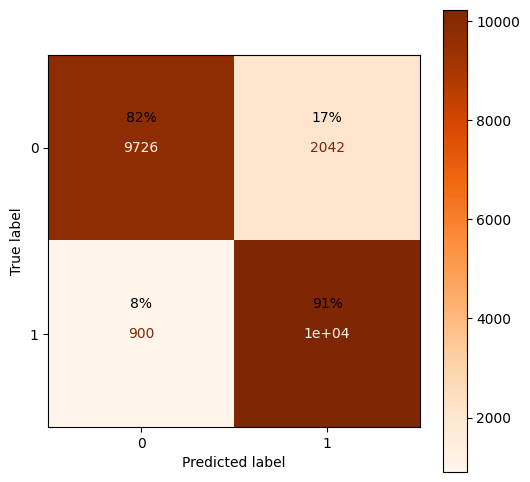

In [106]:
# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate the percentages
cm_percentage = (cm / cm.sum(axis=1)[:, np.newaxis]) * 100
cm_percentage = cm_percentage.round(2)

# Create a ConfusionMatrixDisplay without labels
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
cmd.plot(cmap='Oranges', ax=ax)

# Add the percentages as text annotations in the squares with specified ha and va
for i in range(2):
    for j in range(2):
        # Increase the vertical offset for the percentage text
        offset = 0.2
        ax.text(j, i - offset, f'{int(cm_percentage[i, j])}%', ha='center', va='top', color='black', fontsize=10, fontweight='light', zorder=4)




In [53]:
f1 = f1_score(y_test, y_pred, zero_division="warn")
print('F1 score:', f1)
mcc_score=matthews_corrcoef(y_test, y_pred)
print('MCC score:', mcc_score)
precision = precision_score(y_test, y_pred)
print(f"Precision = {precision}")
recall = recall_score(y_test, y_pred)
print(f"Recall = {recall}")


F1 score: 0.8742627575006411
MCC score: 0.747238922294771
Precision = 0.8335778321108395
Recall = 0.9191229331416247


<font size="5">Make a tree</font>

In [44]:
rf_3 = RandomForestClassifier(max_depth=3, min_samples_leaf=8,n_estimators=100, random_state=42)
rf_3.fit(X_train, y_train)

tree = rf_3.estimators_[0]
# Export the image to a dot file:
export_graphviz(tree, out_file = r'/home/trucbui/PBLGit/random_forest/tree_esm2.dot', feature_names = X.columns, rounded = True, precision = 1)
# Use dot file to create a graph:
(graph, ) = pydot.graph_from_dot_file(r'/home/trucbui/PBLGit/random_forest/tree_esm2.dot')
# Write graph to a png file:
graph.write_png(r'/home/trucbui/PBLGit/random_forest/tree_rf_esm2.png')

In [45]:
y_pred_rf3=rf_3.predict(X_test)
f1 = f1_score(y_test, y_pred_rf3, zero_division="warn")
print('F1 score:', f1)
mcc_score=matthews_corrcoef(y_test, y_pred_rf3)
print('MCC score:', mcc_score)
precision = precision_score(y_test, y_pred_rf3)
print(f"Precision = {precision}")
recall = recall_score(y_test, y_pred_rf3)
print(f"Recall = {recall}")


F1 score: 0.7856579002035813
MCC score: 0.5896176220838385
Precision = 0.7926062536675329
Recall = 0.778830313014827


<font size="5">Make a ROC curve</font>

ROC AUC Score: 0.9628658685591567


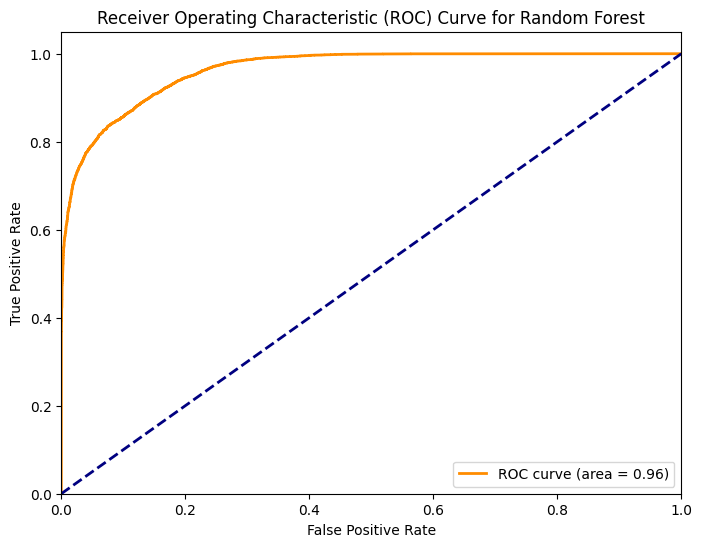

In [36]:
# Get predicted probabilities for the positive class
y_pred_prob = rf.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate the Area Under the ROC Curve (AUC)
roc_auc = auc(fpr, tpr)
print("ROC AUC Score:", roc_auc)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest')
plt.legend(loc='lower right')
plt.show()

<font size="5">Save the model</font>

In [37]:
# save the model to disk
pickle.dump(rf , open(r'/home/trucbui/PBLGit/random_forest/random_forest_final.pk1' , 'wb'))

# load the model from disk
loaded_model = pickle.load(open(r'/home/trucbui/PBLGit/random_forest/random_forest_final.pk1' , 'rb'))

loaded_model_accuracy = loaded_model.score(X_test, y_test)

print("Loaded Model Accuracy:" , loaded_model_accuracy * 100 , "%")




Loaded Model Accuracy: 87.44093706571373 %
